# BiomedParse Inference Demo Notebook

Welcome to the demo notebook for BiomedParse, a comprehensive tool for biomedical image analysis. BiomedParse is designed to simultaneously handle segmentation, detection, and recognition tasks across major biomedical image modalities, providing a unified solution for complex image analysis in biomedical research.

[[`Paper`](https://aka.ms/biomedparse-paper)] [[`Demo`](https://microsoft.github.io/BiomedParse/)] [[`Model`](https://huggingface.co/microsoft/BiomedParse)]  [[`Data`](https://huggingface.co/datasets/microsoft/BiomedParseData)]

## Model Checkpoint Access

The BiomedParse model checkpoint is hosted on [HuggingFace](https://huggingface.co/microsoft/BiomedParse). To access the model:

1. Visit the [model page](https://huggingface.co/microsoft/BiomedParse).
2. Make sure to review and accept the terms of use to gain access to the checkpoint.
3. Retrieve your HuggingFace access token from your user profile.

In [1]:
import os
os.chdir('./BiomedParse')
print(os.getcwd())

/mnt/NAS3/homes/fli40/BiomedParse_demo/BiomedParse


## Setting Up Access

This step ensures secure and authorized access to the model resources.

In [2]:
# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

/mnt/NAS3/homes/fli40/BiomedParse_demo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from huggingface_hub import hf_hub_download

model_file = hf_hub_download(repo_id="microsoft/BiomedParse", filename="biomedparse_v1.pt", local_dir="./pretrained")

print(f"Downloaded model file to: {model_file}")

Downloaded model file to: pretrained/biomedparse_v1.pt


## Load the model weights

In [4]:
from PIL import Image
import torch
import argparse
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed # changed from utils
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES
from inference_utils.inference import interactive_infer_image

conf_files = "./configs/biomedparse_inference.yaml"
opt = load_opt_from_config_files([conf_files])
opt = init_distributed(opt)

model_file = "./pretrained/biomedparse_v1.pt"

model = BaseModel(opt, build_model(opt)).from_pretrained(model_file).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/mnt/NAS3/homes/fli40/BiomedParse_demo/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Deformable Transformer Encoder is not available.


$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([17])


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

def overlay_masks(image, masks, colors):
    overlay = image.copy()
    overlay = np.array(overlay, dtype=np.uint8)
    for mask, color in zip(masks, colors):
        overlay[mask > 0] = (overlay[mask > 0] * 0.4 + np.array(color) * 0.6).astype(np.uint8)
    return Image.fromarray(overlay)

def generate_colors(n):
    cmap = plt.get_cmap('tab10')
    colors = [tuple(int(255 * val) for val in cmap(i)[:3]) for i in range(n)]
    return colors

def process_medical_segmentation(case_id, model, base_path='../sample_ct/', 
                                prompts=None, label_dict=None, 
                                threshold=0.5, figsize=(15, 5), window=None):
    """
    Process medical image segmentation for a given case ID.
    
    Parameters:
    -----------
    case_id : str
        Case identifier (e.g., 'Case_00631')
    model : object
        Pre-trained segmentation model
    base_path : str, optional
        Base directory path for images (default: './sample_ct/')
    prompts : list, optional
        Text prompts for segmentation targets (default: ['liver', 'kidney', 'spleen', 'pancreas'])
    label_dict : dict, optional
        Mapping of organ names to label values (default: standard mapping)
    threshold : float, optional
        Prediction threshold (default: 0.5)
    figsize : tuple, optional
        Figure size for visualization (default: (15, 5))
    
    Returns:
    --------
    dict
        Dictionary containing:
        - 'dice_scores': dict of dice scores for each organ
        - 'pred_masks': list of predicted masks
        - 'gt_masks': list of ground truth masks
        - 'figure': matplotlib figure object
    """
    
    # Set default parameters if not provided
    if prompts is None:
        prompts = ['liver', 'kidney', 'spleen', 'pancreas']
    
    if label_dict is None:
        label_dict = {'liver': 50, 'kidney': 100, 'spleen': 150, 'pancreas': 200}
    
    # Construct file paths
    if window is not None:
        img_path = f'{base_path}{case_id}_{window}.png'
    else:
        img_path = f'{base_path}{case_id}.png'
        
    msk_path = f'{base_path}{case_id}_msk.png'
    
    # Load and process original image
    image = Image.open(img_path, formats=['png'])
    image = image.convert('RGB')
    
    # Get predictions from model
    pred_mask = interactive_infer_image(model, image, prompts)
    
    # Load and process ground truth masks
    gt_masks = []
    gt_mask_all = Image.open(msk_path, formats=['png'])
    
    for prompt in label_dict.keys():
        gt_mask = 1 * (np.array(gt_mask_all.convert('RGB'))[:, :, 0] == label_dict[prompt])
        gt_masks.append(gt_mask)
    
    # Calculate dice scores
    dice_scores = {}
    for i, pred in enumerate(pred_mask):
        if i < len(gt_masks):
            gt = gt_masks[i]
            pred_binary = 1 * (pred > threshold)
            intersection = (pred_binary & gt).sum()
            dice = intersection * 2.0 / (pred_binary.sum() + gt.sum())
            dice_scores[prompts[i]] = dice
            print(f'Dice score for {prompts[i]}: {dice:.4f}')
    
    # Generate colors and overlays
    colors_pred = generate_colors(len(prompts))
    colors_gt = generate_colors(len(gt_masks))
    
    pred_overlay = overlay_masks(image, [1 * (pred_mask[i] > threshold) for i in range(len(prompts))], colors_pred)
    gt_overlay = overlay_masks(image, gt_masks, colors_gt)
    
    # Create legend patches
    legend_patches_pred = [mpatches.Patch(color=np.array(color_pred) / 255, label=prompt) 
                          for color_pred, prompt in zip(colors_pred, prompts)]
    legend_patches_gt = [mpatches.Patch(color=np.array(color_gt) / 255, label=prompt) 
                        for color_gt, prompt in zip(colors_gt, list(label_dict.keys()))]
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(pred_overlay)
    axes[1].set_title("Predictions")
    axes[1].axis('off')
    axes[1].legend(handles=legend_patches_pred, loc='upper right', fontsize='small')
    
    axes[2].imshow(gt_overlay)
    axes[2].set_title("Ground Truth")
    axes[2].axis('off')
    axes[2].legend(handles=legend_patches_gt, loc='upper right', fontsize='small')
    
    plt.tight_layout()
    plt.show()
    
    # Return results
    return {
        'dice_scores': dice_scores,
        'pred_masks': pred_mask,
        'gt_masks': gt_masks,
        'figure': fig
    }

# Run Inference on bdomenCT-1K
https://github.com/JunMa11/AbdomenCT-1K

Dice score for liver: 0.7614
Dice score for kidney: 0.8643
Dice score for spleen: 0.9036
Dice score for pancreas: 0.9113


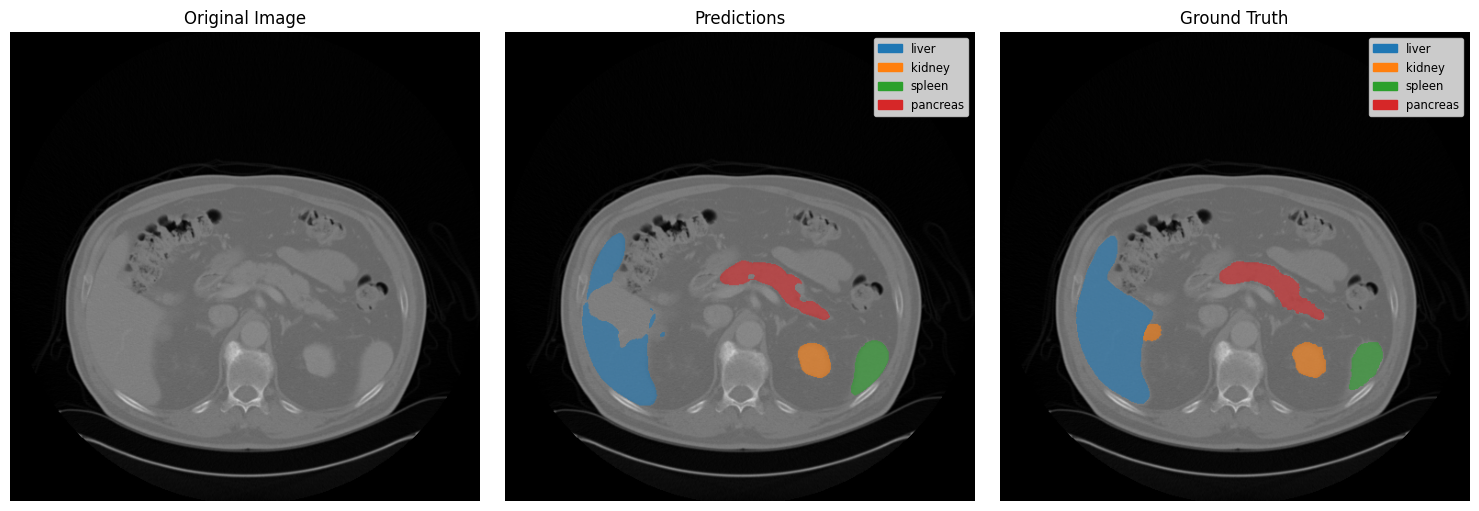

In [6]:
case_id = 'Case_00020'
prompts = ['liver', 'kidney', 'spleen', 'pancreas']

results = process_medical_segmentation(case_id, model, prompts=prompts, window='Original')

### Try different images and organs

In [7]:
## Show the case ids

from glob import glob

case_ids = [i.split('/')[-1][:10] for i in glob('../sample_ct/*.png')]
set(case_ids)

{'Case_00020',
 'Case_00082',
 'Case_00145',
 'Case_00163',
 'Case_00240',
 'Case_00283',
 'Case_00301',
 'Case_00321',
 'Case_00459',
 'Case_00465',
 'Case_00500',
 'Case_00564',
 'Case_00627',
 'Case_00631',
 'Case_00683',
 'Case_00713',
 'Case_00868',
 'Case_00881',
 'Case_00893',
 'Case_01001'}

Dice score for liver: 0.0000
Dice score for kidney: 0.9031
Dice score for spleen: 0.9755
Dice score for pancreas: 0.5318


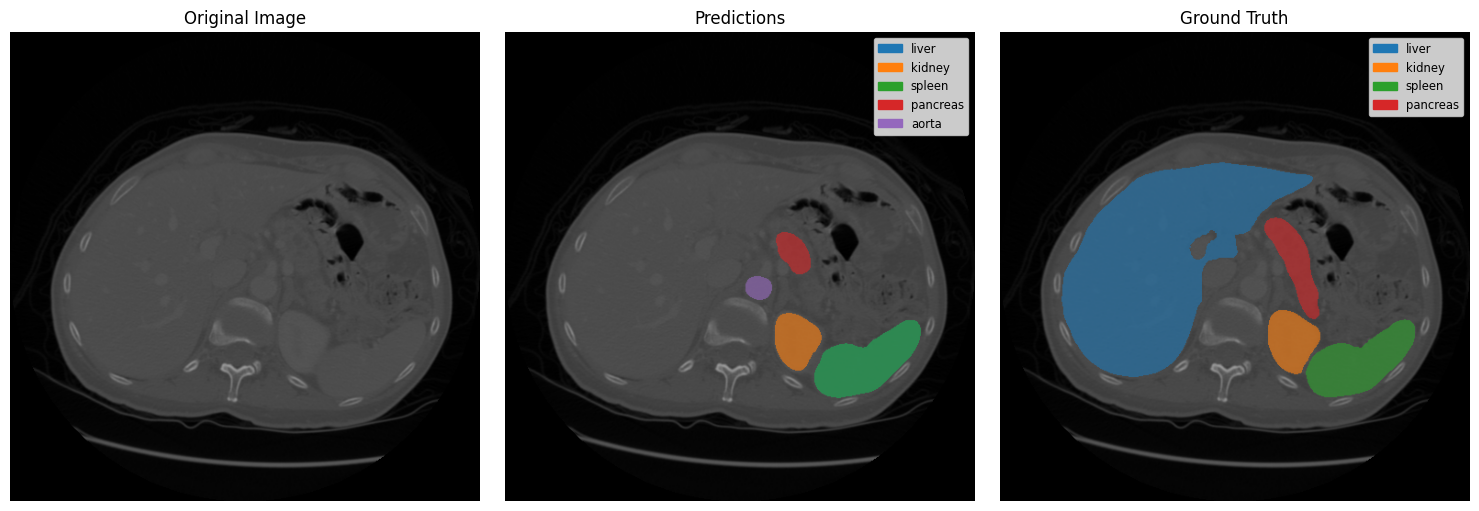

In [8]:
results = process_medical_segmentation('Case_00631', model, prompts=['liver', 'kidney', 'spleen', 'pancreas', 'aorta'], window='Original')

### Different windowing

Dice score for liver: 0.7614
Dice score for kidney: 0.8643
Dice score for spleen: 0.9036
Dice score for pancreas: 0.9113


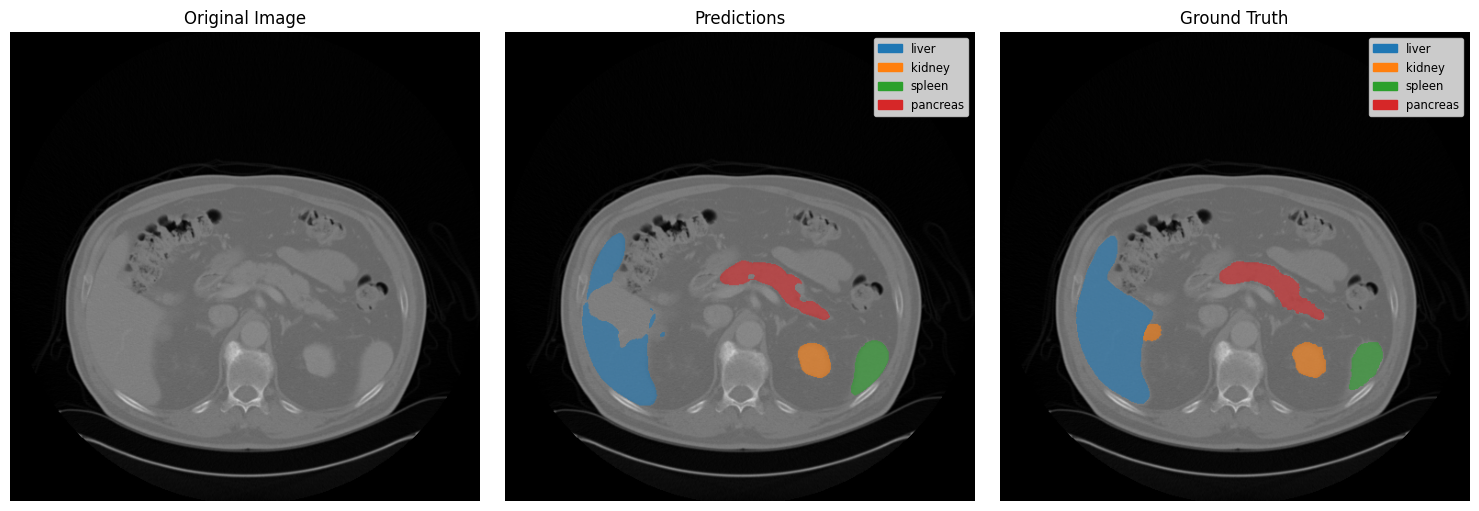

In [9]:
results = process_medical_segmentation('Case_00020', model, prompts=['liver', 'kidney', 'spleen', 'pancreas'], window='Original')

Dice score for liver: 0.0000
Dice score for kidney: 0.8752
Dice score for spleen: 0.0000
Dice score for pancreas: 0.0000


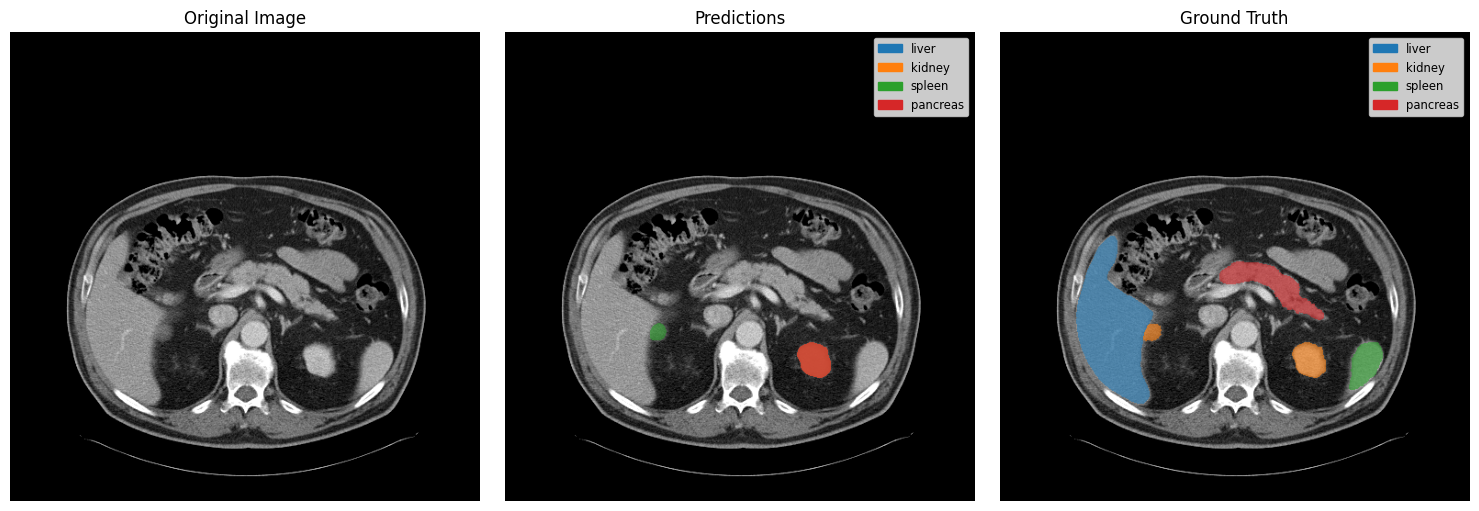

In [10]:
results = process_medical_segmentation('Case_00020', model, prompts=['liver', 'kidney', 'spleen', 'pancreas'], window='SoftTissue')

Dice score for liver: 0.9888
Dice score for kidney: 0.0000
Dice score for spleen: 0.0000
Dice score for pancreas: 0.6113


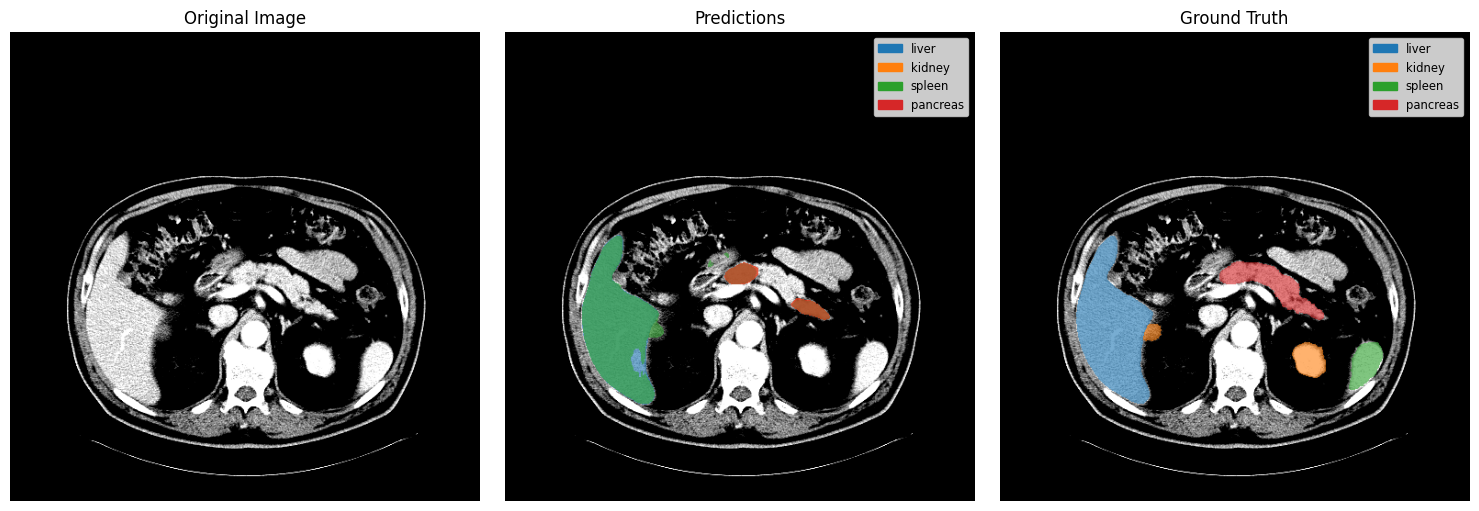

In [11]:
results = process_medical_segmentation('Case_00020', model, prompts=['liver', 'kidney', 'spleen', 'pancreas'], window='Liver')

# Run Inference on SIIM-ACR Pneumothorax dataset
https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation

In [12]:
case_ids = [i.split('/')[-1][:-8] for i in glob('../sample_cxr/*msk.png')]
set(case_ids)

{'1.2.276.0.7230010.3.1.4.8323329.11409.1517875232.812814',
 '1.2.276.0.7230010.3.1.4.8323329.11602.1517875233.861175',
 '1.2.276.0.7230010.3.1.4.8323329.11727.1517875234.495747',
 '1.2.276.0.7230010.3.1.4.8323329.11943.1517875236.566279',
 '1.2.276.0.7230010.3.1.4.8323329.12326.1517875238.596953',
 '1.2.276.0.7230010.3.1.4.8323329.12493.1517875239.385688',
 '1.2.276.0.7230010.3.1.4.8323329.12667.1517875241.45147',
 '1.2.276.0.7230010.3.1.4.8323329.13027.1517875243.170022',
 '1.2.276.0.7230010.3.1.4.8323329.13906.1517875248.601781',
 '1.2.276.0.7230010.3.1.4.8323329.14083.1517875249.540371',
 '1.2.276.0.7230010.3.1.4.8323329.14203.1517875250.226076',
 '1.2.276.0.7230010.3.1.4.8323329.2772.1517875174.628764',
 '1.2.276.0.7230010.3.1.4.8323329.31814.1517875157.8691',
 '1.2.276.0.7230010.3.1.4.8323329.32513.1517875160.958900',
 '1.2.276.0.7230010.3.1.4.8323329.32765.1517875162.241309',
 '1.2.276.0.7230010.3.1.4.8323329.3890.1517875179.988281',
 '1.2.276.0.7230010.3.1.4.8323329.4122.151787

In [13]:
base_path = '../sample_cxr/'

Dice score for pneumothorax: 0.1595


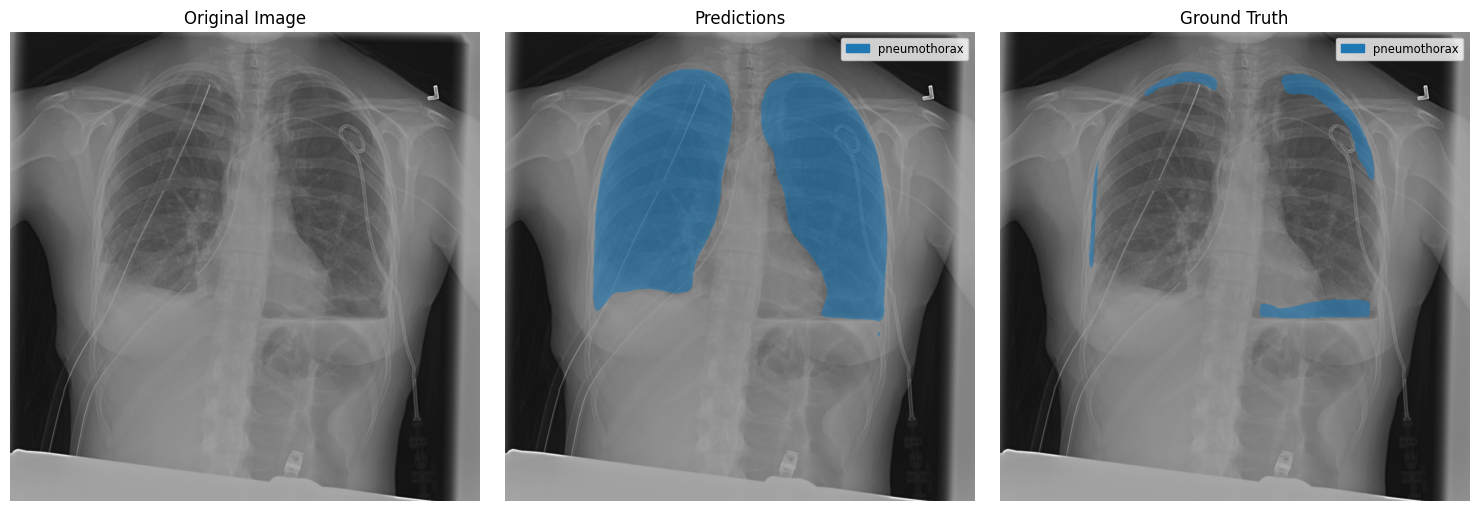

In [14]:
case_id = '1.2.276.0.7230010.3.1.4.8323329.5602.1517875188.985234'
prompts = ['pneumothorax']
label_dict = {'pneumothorax':255}

results = process_medical_segmentation(case_id, model, prompts=prompts, label_dict=label_dict, base_path=base_path)

Dice score for left lung: 0.2285


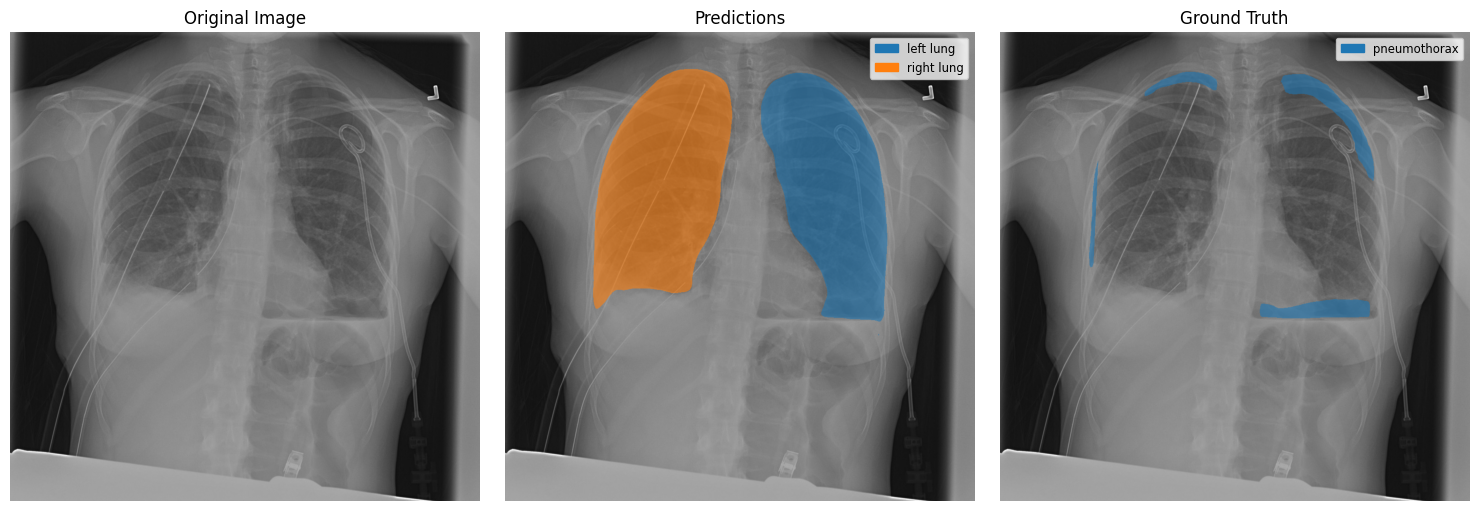

In [15]:
case_id = '1.2.276.0.7230010.3.1.4.8323329.5602.1517875188.985234'
prompts = ['left lung', 'right lung']
label_dict = {'pneumothorax':255}

results = process_medical_segmentation(case_id, model, prompts=prompts, label_dict=label_dict, base_path=base_path)

# Conclusion

1. BiomedParse is capable of performing segmentation tasks across different imaging modalities, although not perfect.
2. Real world performance of the foundation models.
3. Image pre-processing matters.